In [9]:
%reload_ext autoreload
%autoreload 2

In [37]:
from kret_studies import *
from kret_studies.notebook import *
from kret_studies.complex import *

logger = get_notebook_logger()

/Users/Akseldkw/coding/kretsinger/data/nb_log.log


In [38]:
from uml_project import *

HF_DIR, HF_REGISTRY, DEVICE_TORCH, MODEL_DIR

(PosixPath('/Users/Akseldkw/coding/Columbia/UML-Project/data/huggingface'),
 PosixPath('/Users/Akseldkw/coding/Columbia/UML-Project/data/huggingface/REGISTRY.json'),
 device(type='mps'),
 PosixPath('/Users/Akseldkw/coding/Columbia/UML-Project/data/models'))

In [12]:
IMDB_DIR = HF_DIR / "imdb"

In [13]:
df_imdb_train = pd.read_parquet(IMDB_DIR / "train.parquet")
df_imdb_test = pd.read_parquet(IMDB_DIR / "test.parquet")

In [14]:
df = df_imdb_train
test_df = df_imdb_test

In [15]:
stsb_dict = load_dataset("glue", "stsb")

Generating train split:   0%|          | 0/5749 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1500 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1379 [00:00<?, ? examples/s]

In [16]:
df_stsb_train: pd.DataFrame = stsb_dict["train"].to_pandas()  # type: ignore
df_stsb_val: pd.DataFrame = stsb_dict["validation"].to_pandas()  # type: ignore
df_stsb_test: pd.DataFrame = stsb_dict["test"].to_pandas()  # type: ignore

In [17]:
# df_stsb_train.sort_values("label", ascending=False)
# df_stsb_val.sort_values("label", ascending=False)
# df_stsb_test.sort_values("label", ascending=False)

In [18]:
datasets = list(huggingface_hub.list_datasets(dataset_name="stsb"))

In [19]:
word_emb = models.Transformer("bert-base-uncased")
pooling = models.Pooling(word_emb.get_word_embedding_dimension(), pooling_mode_mean_tokens=True)
dense = models.Dense(
    in_features=word_emb.get_word_embedding_dimension(), out_features=128, activation_function=torch.nn.Tanh()
)

model = SentenceTransformer(modules=[word_emb, pooling, dense])

In [20]:
BASE_MODEL = "sentence-transformers/all-MiniLM-L6-v2"  # ABOBA: small, fast
TARGET_DIM = 64  # ABOBA desired embedding dimensionality (experiment with 32,
# 64, 128...)
BATCH_SIZE = 64
POOLER_LR = 2e-4
FINETUNE_LR = 2e-5

In [21]:
EPOCHS_POOLER = 2  # step A epochs (pooler only)
EPOCHS_FINETUNE = 2  # step B epochs (unfreeze and train)

In [22]:
nb_vars = uml_utils.NotebookVars(
    {
        "DEVICE": DEVICE_TORCH_STR,
        "BATCH_SIZE": BATCH_SIZE,
        "POOLER_LR": POOLER_LR,
        "FINETUNE_LR": FINETUNE_LR,
        "EPOCHS_POOLER": EPOCHS_POOLER,
        "EPOCHS_FINETUNE": EPOCHS_FINETUNE,
    }
)

In [23]:
s_model = uml_sentence.build_model(BASE_MODEL, TARGET_DIM, DEVICE_TORCH_STR)

In [ ]:
stsb_vals = uml_utils.df_to_input_examples(df_stsb_val)
train_examples = uml_utils.df_to_input_examples(df_stsb_train, use_labels=True)

In [33]:
FINETUNE = MODEL_DIR / "sentence_transformer_finetuned"
uml_sentence.train_pooler_then_finetune(s_model, train_examples, stsb_vals, out_dir=FINETUNE, notebook_vars=nb_vars)

/Users/Akseldkw/micromamba/envs/kret_312/lib/python3.12/site-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/Users/Akseldkw/micromamba/envs/kret_312/lib/python3.12/site-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have 

Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
wandb: Currently logged in as: akseldkw (akseldkw07) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the for

/Users/Akseldkw/micromamba/envs/kret_312/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss,Validation Loss,Sts-val Pearson Cosine,Sts-val Spearman Cosine
90,No log,No log,0.842577,0.845936
180,No log,No log,0.846435,0.849271


Step,Training Loss,Validation Loss,Sts-val Pearson Cosine,Sts-val Spearman Cosine
90,No log,No log,0.752006,0.781267
180,No log,No log,0.733424,0.766637


In [31]:
len(stsb_vals), df_stsb_train.shape

(1500, (5749, 4))

In [40]:
from uml_project.uml_models import uml_eval

In [41]:
uml_eval.evaluate_sts(s_model, stsb_vals)

{'sts-eval_pearson_cosine': 0.7334244862836743,
 'sts-eval_spearman_cosine': 0.7666369053988303}

In [ ]:
sentences = [ex.texts[0] for ex in stsb_vals][:1000]  # first sentence of pairs, subset
embeddings = model.encode(sentences, show_progress_bar=True, convert_to_numpy=True)
print("Embeddings shape:", embeddings.shape)

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Embeddings shape: (1000, 128)


In [44]:
pca_df = uml_eval.compute_pca_explained_variance(embeddings, n_components=50)

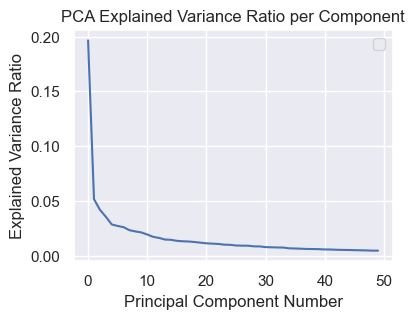

In [ ]:
fig, ax = uks_mpl.subplots(1, 1, 4, 3)
ax.plot(pca_df["explained_var"])
ax.set_xlabel("Principal Component Number")
ax.set_ylabel("Explained Variance Ratio")
ax.set_title("PCA Explained Variance Ratio per Component")
fig

In [ ]:
cov = np.cov(embeddings, rowvar=False)
eigvals = np.linalg.eigvalsh(cov)  # ascending
eigvals = eigvals[eigvals > 0]
pr = uml_eval.participation_ratio(np.sqrt(eigvals))

In [51]:
pr

np.float64(19.068535356006628)